### Import, junção dos datasets, pre-processamento

#### import

In [1]:
import pandas as pd
import numpy as np

M2BR = pd.read_csv('MYAGM2BRM189N.csv') #
M2US = pd.read_csv('WM2NS.csv') #
#GPDBR = pd.read_csv('NGDPNSAXDCBRQ.csv') # tem efeito inflacionario bimestral
GPDBR = pd.read_csv('NGDPRXDCBRA.csv') # anual
GPDUS = pd.read_csv('GDPA.csv') #
OIL = pd.read_csv('POILBREUSDM.csv') #

M2BR.rename(columns={'observation_date': 'date', 'MYAGM2BRM189N': 'value'}, inplace=True)
GPDUS.rename(columns={'observation_date': 'date', 'GDPA': 'value'}, inplace=True)
M2US.rename(columns={'observation_date': 'date', 'WM2NS': 'value'}, inplace=True)
#GPDBR.rename(columns={'observation_date': 'date', 'NGDPNSAXDCBRQ': 'value'}, inplace=True)
GPDBR.rename(columns={'observation_date': 'date', 'NGDPRXDCBRA': 'value'}, inplace=True)
OIL.rename(columns={'observation_date': 'date' ,'POILBREUSDM': 'value'}, inplace=True)

M2BR['value'] = M2BR['value'] / 1_000_000_000
GPDBR['value'] = GPDBR['value'] / 1_000

#####################################################################################
# Os índices devem ser ajustados por estarem em escalas e frequencias diferentes.
# M2BR: [mensal - 1970 a  2017]     M2 Money Stock Brasil   (em dólares)
# M2US: [semanal - 1980 - 2025]     M2 Money Stock EUA      (em bilhões de dólares)
# GPDBR: [bimestral - 1996 - 2024]  PIB Brasil              (em milhões de dólares)
# GPDUS: [anual - 1929 - 2024]      PIB EUA                 (em bilhões de dólares)
# OIL: [mensal - 1990 a 2025]       Preço do petróleo Brent (em dólares por barril)
#######################################################################################


#### criação de features baseada nos dados crus

In [2]:
idx = pd.date_range(start='1970-01-01', end='2025-12-31', freq='D')
df_all = pd.DataFrame(index=idx)
df_all.index.name = 'date'
# — OIL (mensal)
oil_s = OIL.copy()
oil_s['date'] = pd.to_datetime(oil_s['date'])
oil_s = oil_s.set_index('date')['value']      # Series indexada por date
df_all['oil'] = oil_s   
# — M2US (semanal)
m2us_s = M2US.copy()
m2us_s['date'] = pd.to_datetime(m2us_s['date'])
m2us_s = m2us_s.set_index('date')['value']
df_all['m2us'] = m2us_s
# — M2BR (mensal)
m2br_s = M2BR.copy()
m2br_s['date'] = pd.to_datetime(m2br_s['date'])
m2br_s = m2br_s.set_index('date')['value']
df_all['m2br'] = m2br_s
# — GPDBR (bimestral)
gpdbr_s = GPDBR.copy()
gpdbr_s['date'] = pd.to_datetime(gpdbr_s['date'])
gpdbr_s = gpdbr_s.set_index('date')['value']
df_all['gp dbr'] = gpdbr_s
# — GPDUS (anual)
gpdus_s = GPDUS.copy()
gpdus_s['date'] = pd.to_datetime(gpdus_s['date'])
gpdus_s = gpdus_s.set_index('date')['value']
df_all['gpdus'] = gpdus_s

df_all = df_all.reset_index()
df_all = df_all.rename(columns={'index':'date'})# caso tenha virado coluna chamada ‘index’
df_all = df_all.set_index('date')

H = 4  # horizonte de 4 semanas
pct_fwd = df_all['oil'].pct_change(periods=H).shift(-H)
df_all['regime'] = (pct_fwd > 0.05).astype(int)  
# 1 = alta (>5% em 4 semanas), 0 = não alta
# Criar variáveis adicionais derivadas para enriquecer o modelo
df_all['oil_lag1'] = df_all['oil'].shift(1) # LAGs - Memória de curto prazo
df_all['oil_ma4'] = df_all['oil'].rolling(4).mean() # Media movel - Tendência suavizada
df_all['m2us_pct1'] = df_all['m2us'].pct_change(1) # Dif percentual - Mudanças instantâneas
# Capturar sazonalidade
df_all['month'] = df_all.index.month #
month_dummies = pd.get_dummies(df_all['month'], prefix='month', drop_first=True) # evita multicolinearidade
df_all = pd.concat([df_all, month_dummies], axis=1) # 
df_all.drop(columns='month', inplace=True) #
df_all['gpdus_lag1'] = df_all['gpdus'].shift(52) # Indicadores macro - PIB anual anterior como contexto


C:\Users\Pablo Monteiro\AppData\Local\Temp\ipykernel_41912\355701226.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_fwd = df_all['oil'].pct_change(periods=H).shift(-H)
C:\Users\Pablo Monteiro\AppData\Local\Temp\ipykernel_41912\355701226.py:41: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_all['m2us_pct1'] = df_all['m2us'].pct_change(1) # Dif percentual - Mudanças instantâneas


#### Preenchimento das features de informação processadas a partir dos dados brutos

In [3]:
lista_de_features = [
    'oil_lag1',
    'oil_ma4',
    'm2us_pct1',
    # dummies de mês
    'month_2','month_3','month_4','month_5','month_6',
    'month_7','month_8','month_9','month_10','month_11','month_12',
    'gpdus_lag1',
]

# cópia do df_all para não tocar no original
df_imp = df_all.copy()
# Preencher preços de fechamento e estoques com ffill
for col in ['oil', 'm2us', 'm2br', 'gp dbr']:
    df_imp[col] = df_imp[col].ffill()
# Para PIB US (único anual), interpolação linear
df_imp['gpdus'] = df_imp['gpdus'].interpolate(method='linear', limit_direction='both')
# Lags e médias para o Brent
df_imp['oil_lag1'] = df_imp['oil'].shift(1)
df_imp['oil_ma4']  = df_imp['oil'].rolling(window=4).mean()
# Variação percentual de M2 US
df_imp['m2us_pct1'] = df_imp['m2us'].pct_change(periods=1).fillna(0)
# Lag 1 de GDP US
df_imp['gpdus_lag1'] = df_imp['gpdus'].shift(1)
# Dummies de mês
df_imp['month'] = df_imp.index.month
month_dummies = pd.get_dummies(df_imp['month'], prefix='month', drop_first=True)
df_imp = pd.concat([df_imp, month_dummies], axis=1)
df_imp.drop(columns='month', inplace=True)

df_imp.index = pd.to_datetime(df_imp.index)


#### Plot dos dados

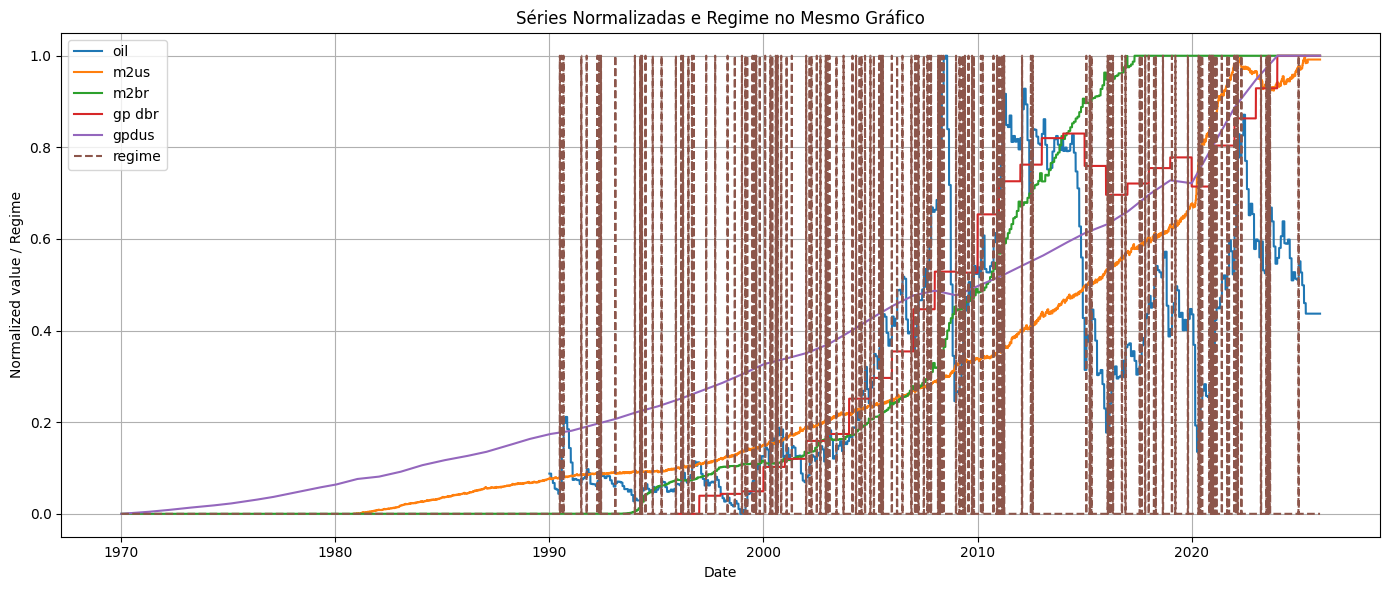

In [4]:
def plot_model_base():
    import matplotlib.pyplot as plt
    # --- 1. Cria df_imp e imputa ---
    df_imp = df_all.copy()
    for col in ['oil', 'm2us', 'm2br', 'gp dbr']:
        df_imp[col] = df_imp[col].ffill()
    df_imp['gpdus'] = df_imp['gpdus'].interpolate(method='linear', limit_direction='both')

    # --- 2. Gera regime (exemplo: alta >5% em 4 semanas) ---
    H = 4
    df_imp['regime'] = (df_imp['oil'].pct_change(periods=H).shift(-H) > 0.05).astype(int)

    # --- 3. Normaliza cada série para [0,1] ---
    series = ['oil', 'm2us', 'm2br', 'gp dbr', 'gpdus']
    df_norm = df_imp[series].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # --- 4. Plota tudo no mesmo gráfico ---
    plt.figure(figsize=(14, 6))
    for col in series:
        plt.plot(df_norm.index, df_norm[col], label=col)
    plt.plot(df_imp.index, df_imp['regime'], label='regime', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Normalized value / Regime')
    plt.title('Séries Normalizadas e Regime no Mesmo Gráfico')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_model_base()

#### Separação da região de dados rica em informações

In [5]:
mask = df_imp.index.to_series().between('1996-01-01','2017-12-31')
print(mask.sum(), "linhas dentro de 1996–2017 de um total de", len(mask))

df_rich = df_imp.loc['1996-01-01':'2017-12-31']
print("df_rich linhas:", df_rich.shape[0])

df_imp.regime.value_counts()

8036 linhas dentro de 1996–2017 de um total de 20454
df_rich linhas: 8036


regime
0    19922
1      532
Name: count, dtype: int64

#### Plot da região de dados rica em informações

##### def do plot

In [6]:
def plot_rich_base():
    import matplotlib.pyplot as plt
    # --- 1. Cria df_imp e imputa ---
    for col in ['oil', 'm2us', 'm2br', 'gp dbr']:
        df_rich[col] = df_rich[col].ffill()
    df_rich['gpdus'] = df_rich['gpdus'].interpolate(method='linear', limit_direction='both')

    # --- 2. Gera regime (exemplo: alta >5% em 4 semanas) ---
    H = 4
    df_rich['regime'] = (df_rich['oil'].pct_change(periods=H).shift(-H) > 0.05).astype(int)

    # --- 3. Normaliza cada série para [0,1] ---
    series = ['oil', 'm2us', 'm2br', 'gp dbr', 'gpdus']
    df_norm = df_rich[series].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # --- 4. Plota tudo no mesmo gráfico ---
    plt.figure(figsize=(14, 6))
    for col in series:
        plt.plot(df_norm.index, df_norm[col], label=col)
    plt.plot(df_rich.index, df_rich['regime'], label='regime', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Normalized value / Regime')
    plt.title('Séries Normalizadas e Regime no Mesmo Gráfico')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##### Plot

C:\Users\Pablo Monteiro\AppData\Local\Temp\ipykernel_41912\551900404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rich[col] = df_rich[col].ffill()
C:\Users\Pablo Monteiro\AppData\Local\Temp\ipykernel_41912\551900404.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rich['gpdus'] = df_rich['gpdus'].interpolate(method='linear', limit_direction='both')
C:\Users\Pablo Monteiro\AppData\Local\Temp\ipykernel_41912\551900404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

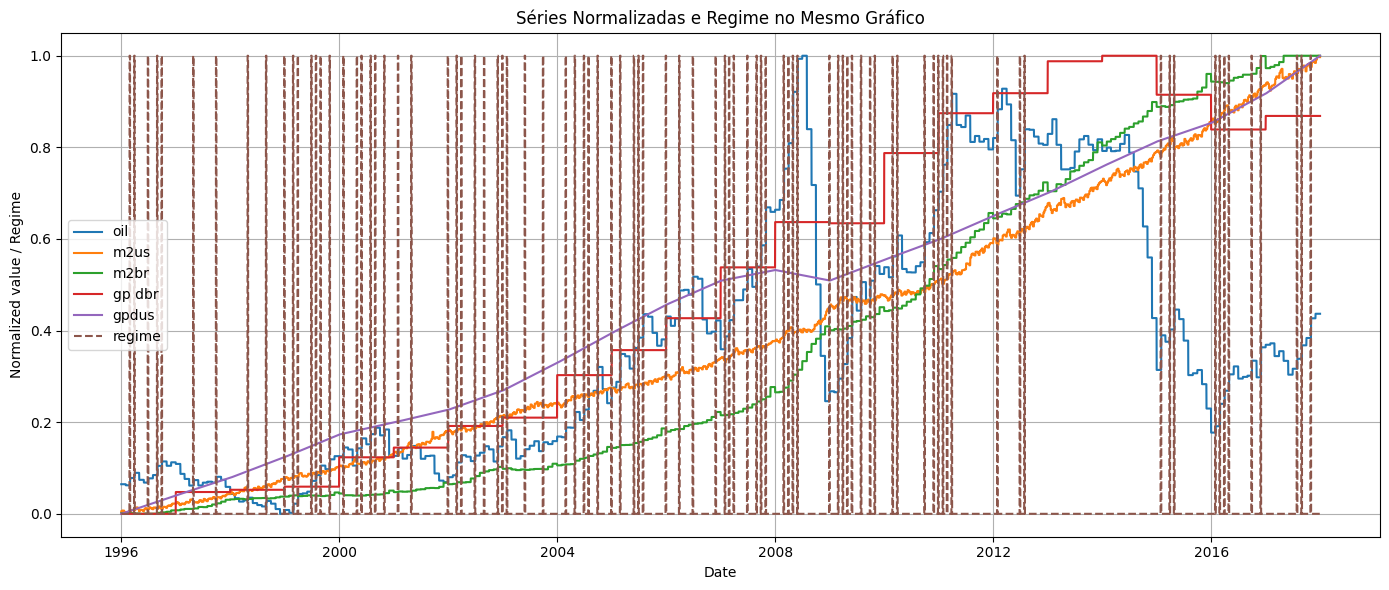

In [7]:
plot_rich_base()

### Otimização dos dados e modelagem

In [8]:
df_imp.regime.value_counts()
#####################################################################################
# Até aqui, os datasets foram baixados, processados e visualizados.
# A idea é criar um modelo de machine learning que preveja o regime de alta do petróleo
# (1 = alta, 0 = não alta) com base nas variáveis econômicas.
# A partir daqui será utilizado um algoritmo de otimização de hiperparâmetros
# (como GridSearchCV ou RandomizedSearchCV) para encontrar os melhores parâmetros do modelo.
# Além disso, serão criadas métricas de avaliação como acurácia, precisão, recall e F1-score.
# Também serão gerados gráficos de curva ROC e matriz de confusão para avaliar o desempenho do modelo.
#######################################################################################
df_imp.regime.value_counts()
x = df_rich[lista_de_features]
y = df_rich['regime']

from sklearn.model_selection import train_test_split
SEED = 123
X, x_test, Y, y_test = train_test_split(x, y, random_state = SEED, stratify = y, test_size = 0.15)
x_treino, x_val, y_treino, y_val = train_test_split(X, Y, random_state = SEED, stratify = Y, test_size = 0.15)



### Modelos e parâmetros

In [9]:
"""### Modelos e parâmetros"""

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models_and_parameters = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            'clf__criterion': ['gini', 'entropy'],
            'clf__max_depth': [None, 6, 8, 10, 12]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            'clf__n_estimators': [10, 50, 100],
            'clf__max_depth': [None, 6, 10],
            'clf__criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=100, random_state=SEED),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        }
    }
}


### Nested Cross Validation em GridSearch no pipeline com SMOTE

#### gridsearch aninhado

In [10]:

"""### Nested Cross Validation em GridSearch no pipeline com SMOTE"""

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

results = {}

for name, mp in models_and_parameters.items():
    # pipeline com SMOTE e placeholder
    pipeline = imbpipeline([
        ('oversample', SMOTE(random_state=SEED)),
        ('clf', mp['model'])
    ])

    # GridSearch interno
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=mp['params'],
        scoring='recall',
        cv=inner_cv,
        n_jobs=-1
    )

    # Nested CV
    nested_scores = cross_val_score(
        grid, X, Y,
        cv=outer_cv,
        scoring='recall',
        n_jobs=-1
    )

    results[name] = {
        'nested_mean_recall': np.mean(nested_scores),
        'nested_std_recall': np.std(nested_scores),
        'grid_search': grid
    }

    print(f"{name}: recall médio aninhado = {results[name]['nested_mean_recall']:.3f} "
          f"(+/- {results[name]['nested_std_recall']:.3f})")


DecisionTree: recall médio aninhado = 0.715 (+/- 0.071)
RandomForest: recall médio aninhado = 0.702 (+/- 0.049)
KNN: recall médio aninhado = 0.898 (+/- 0.063)
LogisticRegression: recall médio aninhado = 0.396 (+/- 0.068)


#### Melhor modelo desempenhado

In [11]:

"""#### Melhor modelo desempenhado"""

# 4. Selecionar melhor modelo
best_model_name = max(results, key=lambda k: results[k]['nested_mean_recall'])
best_entry = results[best_model_name]
print(f"\nMelhor modelo: {best_model_name} com recall médio aninhado = {best_entry['nested_mean_recall']:.3f}")



Melhor modelo: KNN com recall médio aninhado = 0.898


#### Treino baseado no melhor modelo e melhor hiperparâmetros

In [12]:

"""#### Treino baseado no melhor modelo e melhor hiperparâmetros"""

# 5. Treinar GridSearch no conjunto completo para obter hiperparâmetros ótimos
best_grid = best_entry['grid_search']
best_grid.fit(X, Y)
print(f"Melhores parâmetros: {best_grid.best_params_}")


Melhores parâmetros: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}


### Avaliação de desemepenho

In [13]:

"""### Avaliação de desemepenho"""

# 6. Avaliar no conjunto de teste ---
from sklearn.metrics import classification_report, recall_score

# Previsões
y_pred = best_grid.predict(x_test)

print("Classification Report no conjunto de teste:")
print(classification_report(y_test, y_pred))
print(f"Recall no teste: {recall_score(y_test, y_pred):.3f}")


Classification Report no conjunto de teste:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1152
           1       0.40      0.96      0.57        54

    accuracy                           0.93      1206
   macro avg       0.70      0.95      0.76      1206
weighted avg       0.97      0.93      0.95      1206

Recall no teste: 0.963


#### Modelo Melhor performance otimizado

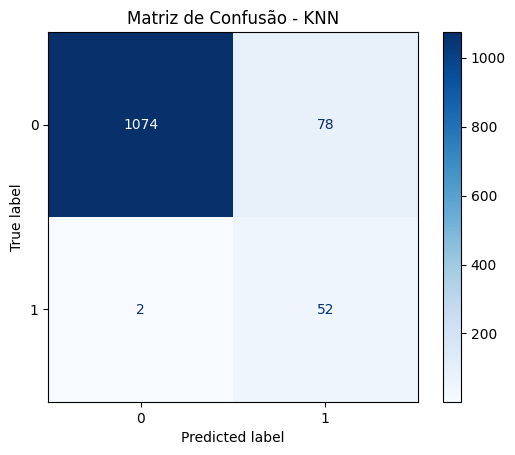

In [14]:

"""#### Modelo Melhor performance otimizado"""

# 8. Matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_grid.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()


#### Modelo Tree sem otimizações

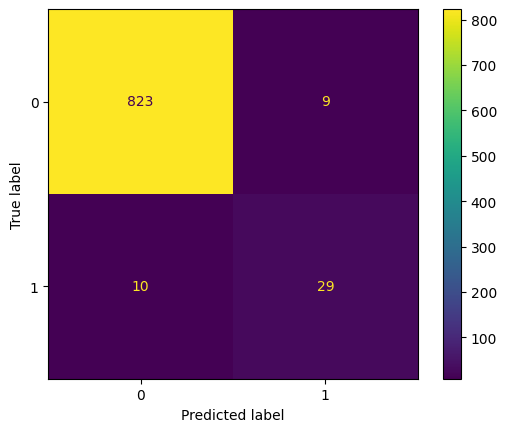

In [15]:

"""#### Modelo Tree sem otimizações"""

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
x_treinoP, x_val, y_treinoP, y_val = train_test_split(x_treino, y_treino, random_state = SEED, stratify = y_treino, test_size = 0.15)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
tree.fit(x_treinoP, y_treinoP)
y_predict = tree.predict(x_val)
matrix = confusion_matrix(y_val, y_predict)
grafico = ConfusionMatrixDisplay(matrix, display_labels=tree.classes_)
grafico.plot()
